In [ ]:
# Inspired from keras example guide found at (https://keras.io/examples/nlp/text_classification_from_scratch/)
# Written by Mark Omernick, Francois Chollet
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Download the imdb review data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

# Keep only the pos and neg reviews to be used
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  15.5M      0  0:00:05  0:00:05 --:--:-- 18.4M


In [ ]:
# Separate the data into batches
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "training",
    seed = 382,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed = 382,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size = batch_size
)

# Show example of dataset
movie_reviews = list(raw_test_ds.as_numpy_iterator())
print(movie_reviews[0][0][0])
print(movie_reviews[0][1][0])

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
b"This is possibly one of the worst movies I have had the dis-pleasure of watching in my entire life. The plot is ridiculous and the characters are horrible people. I watched this film with 3 friends and we all agreed to turn it off 30 minutes before the end. Ben Kingsley's character is just plain stupid but not funny at all. It is a wonder why an actor of his talent would be involved in such tripe. Tea Leoni does a fine Hillary Clinton impression throughout to portray the very cold and uninteresting female lead who has all the endearing qualities of a broom handle. Throw in a pointless and unexplained sub-plot and a horribly cringe worthy montage, and you end up with a waste of 93 minutes (60 in my case). Avoid this film at all costs!"
0


In [ ]:
# Prepare the data
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

# This function removes  the '<br />' tags from the text
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

In [ ]:
# Model constants
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [ ]:
# Text vectorization
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length = sequence_length,
)

# Make a text-only dataset
text_ds = raw_train_ds.map(lambda x, y: x)
# Call adapt
vectorize_layer.adapt(text_ds)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# Vectorize the data
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefectching for better performance on GPU
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [ ]:
from tensorflow.keras import layers

# An integer input for vocab indices
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="same", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

# We add a vanilla hidden layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We projectt onto a single unit output layer, and squash it with a sigmoid
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

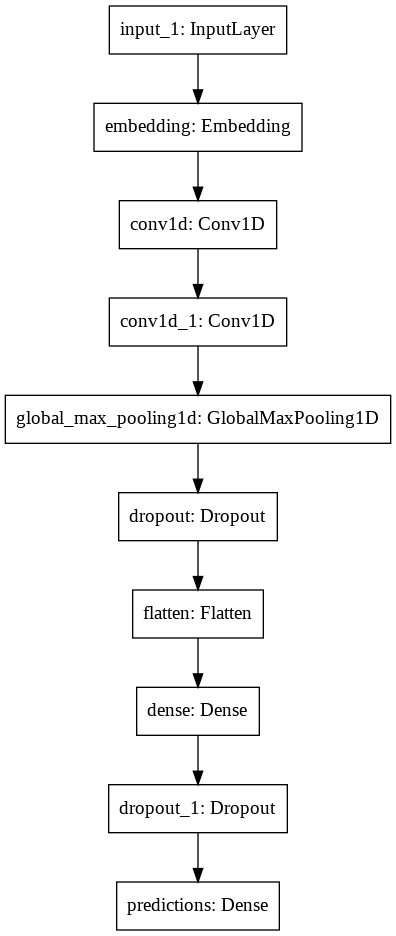

In [ ]:
keras.utils.plot_model(model)

In [ ]:
epochs = 2

# Fit the model using the train and test datasets
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/2
625/625 [==============================] - 110s 174ms/step - loss: 0.6164 - accuracy: 0.6041 - val_loss: 0.3239 - val_accuracy: 0.8624
Epoch 2/2
625/625 [==============================] - 103s 165ms/step - loss: 0.2672 - accuracy: 0.8943 - val_loss: 0.3978 - val_accuracy: 0.8650


In [ ]:
# Evaluate the model
model.evaluate(test_ds)

782/782 [==============================] - 33s 42ms/step - loss: 0.4021 - accuracy: 0.8580


[0.402133584022522, 0.8579999804496765]

In [ ]:
# Make an end-to-end model so that we can pass raw_strings into it

# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end-to-end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with 'raw_test_ds', which has raw strings
end_to_end_model.evaluate(raw_test_ds)

782/782 [==============================] - 37s 46ms/step - loss: 0.4109 - accuracy: 0.8550


[0.4021335244178772, 0.8579999804496765]

In [ ]:
additional_reviews = np.array([["Absolutely nothing about this makes sense. From the fact that the girl kind of had to start teaching sign language to Kong by the time she was 1 week old, to the hollow earth ridiculous theory of a guy that wrote a book nobody bought but suddenly caught the eye of a Mexican gazillionaire with Mexican accent but an Amrican name that took a couple of months to build the technology that must have taken at least 15 years to design, test, and build. Nothing makes any sense whatsoever. Yes, the special effects and sound might be good but nothing else does.",
                         "GODzilla Vs KINGkong . It's a feast to eyes for action lovers . It's the movie all the fans of Godzilla & King kong are waiting for . The script , direction and visual effects are done wonderfully . There is not even one dull moment in the film , unlike previous two Godzilla movies . There are some goosebumps moments which makes people scream . Millie brown , Brian , Julian made some funny moments . This movie being released first in India , one week before USA release Is a smart move . Result of which most of the people in India can watch this epic in theaters . This is not a movie to be watched in OTT or pirated print or DVD . Experience this epic in nearest theatres , take all precautions of covid .",
                         "While Melissa McCarthy can be funny (I enjoyed The Heat and Spy), it's obvious no matter the studio, everything McCarthy and her husband, Ben Falcone, offer up is immediately greenlit. That has to stop. This is the umpeeth unfunny movie by the married duo. After the first 30 minutes, I simply had the movie on in the background, but could still hear McCarthy's ad-libs which were excruciatingly awful. If this is the best an immensely talented actress like Octavia Spencer has to pick from, that's a sad commentary on the state of comedic films. Let's hope she got a big, upfront payday.",
                         "Last movie I saw was Minari, it was great, but sometimes watching something silly that doesn't invoke a lot of emotion is good for the soul too. After a long week of work and being tired and needing to unwind I watched this and found it really entertaining. Laughed out loud throughout the whole movie. If you like Melissa McCarthy then you'll enjoy this. Especially with her teamed up with Jason Bateman again. If you are looking for something to stimulate you intellectually this isn't the movie but it isn't intended to be either.",
                         "I know a movie is hardly as good as the book, but come on... HP 4 was a great movie, and so were the others. This lacks of plot (well, the book's, for it has Ron's romantic life as one) and of details: Dumbledore's chat about horcruxes and possible ones. Ginny and Harry's REAL kiss. Fleur and the wedding, very important in the next. the OTHER minister. Fenrir Grayback Tonk's patronus and explanation the funeral. It isn't that I expected a faithful adaptation, but those are important details. I loved the way you can kill the Headmaster and then walk through the corridors, even destroying the Great Hall without no one waking up nor listening, and also do an fatal curse like Sectumsempra and not getting even detention...Hardly a decent movie, it could have been better, MUCH better. It's a shame that nowadays most directors only care to make money...",
                         "HP6 is a dark and emotionally thrilling masterpiece. It combines magical awes that appeal mostly to children as well as mature and dark themes that appeal to almost everyone. It discovers the dark and mysterious past of you-know-who and leaves the audience aching for more as its two and half hours run time go by in a flash. The film contains dazzling visuals and terrific cinematography. It is indeed a satisfying experience that will please just about everyone. One thing is for certain though: in resemblance to the Rowling novels, the film series seems to get darker and more mature with every passing film while keeping an incredible PG rating (in the exception of HP4 & 5). This film not only has some bangs and booms but also explores the theme of teenage love as the three protagonists find themselves tangled in teenage romances. Overall a top notch film worth seeing over and over. Cant wait for the arrival of the Deathly Hallows."],
                       [0,1,0,1,0,1]])
print(additional_reviews[0])

['Absolutely nothing about this makes sense. From the fact that the girl kind of had to start teaching sign language to Kong by the time she was 1 week old, to the hollow earth ridiculous theory of a guy that wrote a book nobody bought but suddenly caught the eye of a Mexican gazillionaire with Mexican accent but an Amrican name that took a couple of months to build the technology that must have taken at least 15 years to design, test, and build. Nothing makes any sense whatsoever. Yes, the special effects and sound might be good but nothing else does.'
 "GODzilla Vs KINGkong . It's a feast to eyes for action lovers . It's the movie all the fans of Godzilla & King kong are waiting for . The script , direction and visual effects are done wonderfully . There is not even one dull moment in the film , unlike previous two Godzilla movies . There are some goosebumps moments which makes people scream . Millie brown , Brian , Julian made some funny moments . This movie being released first in 

In [ ]:
predictions = end_to_end_model.predict(additional_reviews[0])
print(predictions)

[[0.03346896]
 [0.74434125]
 [0.28694433]
 [0.9793265 ]
 [0.35601255]
 [0.9962232 ]]
